In [ ]:
# !pip install category_encoders

In [82]:
%matplotlib inline
import numpy as np
import pandas as pd
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pointbiserialr, spearmanr
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, RobustScaler
from catboost import CatBoostClassifier

In [2]:
data = pd.read_csv('data/adult.csv')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 1 to 32560
Columns: 105 entries, age to native.country_Yugoslavia
dtypes: float64(5), int32(1), int64(8), uint8(91)
memory usage: 6.0 MB


Построим гистограмму значений для каждой непрерывной функции

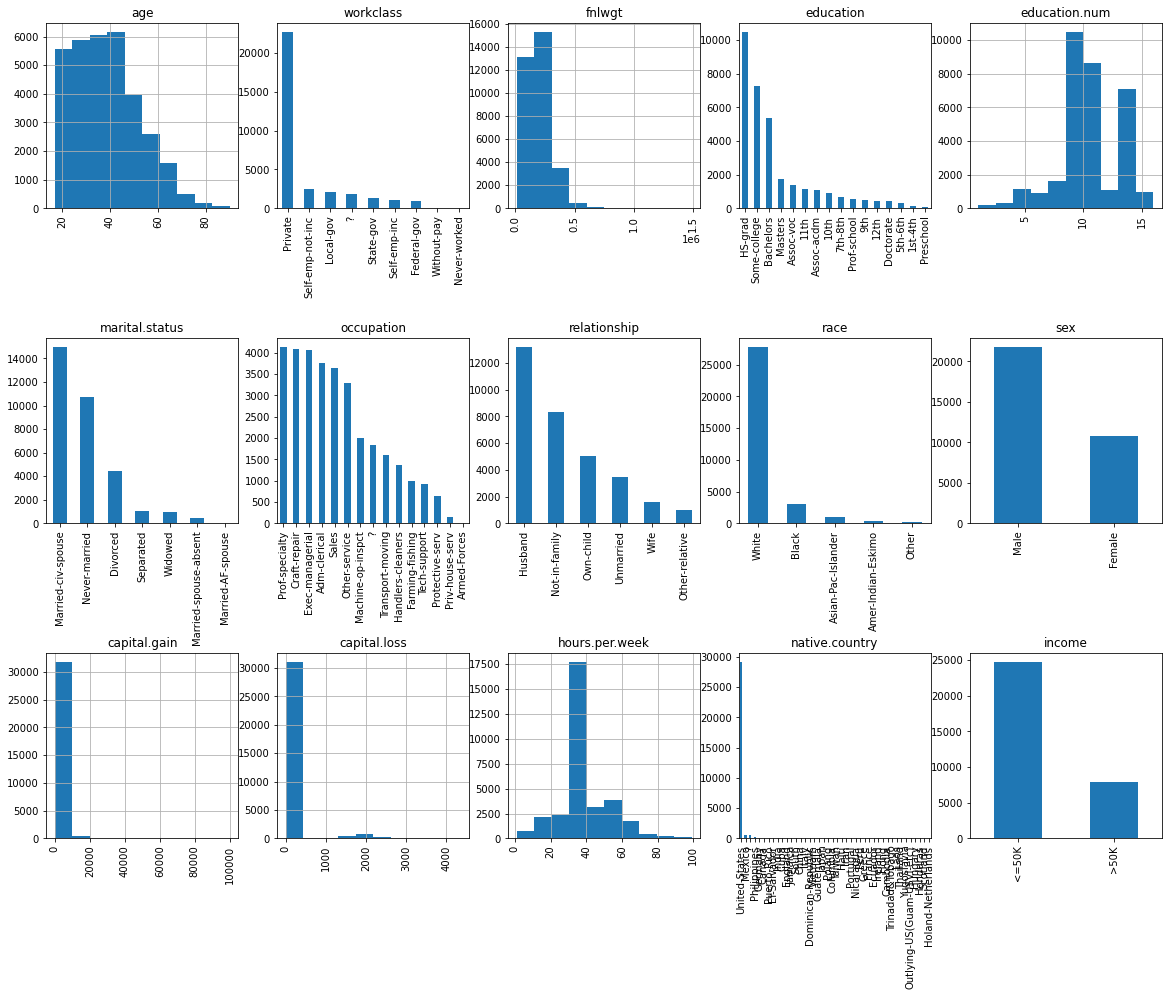

In [3]:
fig = plt.figure(figsize=(20,15))
cols = 5
rows = float(data.shape[1]) / cols
for i, column in enumerate(data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data.dtypes[column] == 'object':
        data[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [4]:
first_class = data[data['income'] == '<=50K'].shape[0]
second_class = data[data['income'] == '>50K'].shape[0]

print(f'Individuals making at most $50.000: {first_class}')
print(f'Individuals making more than $50.000: {second_class}')

Individuals making at most $50.000: 24720
Individuals making more than $50.000: 7841


In [5]:
percentage_first = first_class / len(data['income'])
percentage_second =  1 - percentage_first

print(f'First class == {percentage_first:.2f}%')
print(f'Second class == {percentage_second:.2f}%')

First class == 0.76%
Second class == 0.24%


In [6]:
unique_values = []
for column in data.columns:
    unique_values.append([column, len(data[column].value_counts())])
    
unique_values

[['age', 73],
 ['workclass', 9],
 ['fnlwgt', 21648],
 ['education', 16],
 ['education.num', 16],
 ['marital.status', 7],
 ['occupation', 15],
 ['relationship', 6],
 ['race', 5],
 ['sex', 2],
 ['capital.gain', 119],
 ['capital.loss', 92],
 ['hours.per.week', 94],
 ['native.country', 42],
 ['income', 2]]

In [199]:
for c in data.columns:
    count_non = data[c].isin(['?']).sum()
    if count_non > 0:
        print(f'Название признака {c}')
        print(f'Кол-во пропущенных значений в признаке {count_non}')
        print(f'Кол-во пропущенных значений в процентах {(float(count_non) / data.shape[0] * 100):.2f}%')

In [8]:
# Можно использовать RobustScaler для всего датасета, т.к. он устойчив к выбросам
def preprocess_numerical(data):
    numerical = ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
    
    scaler = StandardScaler() #RobustScaler()
    data[numerical] = scaler.fit_transform(data[numerical])
    return data

In [9]:
def preprocess_сategories(data):
    data = data[data['workclass'] != '?']
    data = data[data['occupation'] != '?']
    data = data[data['native.country'] != '?']
    
    ohe_list = ['sex', 'race']
    dummy_list = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'native.country']

    ohe = ce.OneHotEncoder(cols=ohe_list)
    oe = ce.OrdinalEncoder()

    data = pd.get_dummies(data, columns=dummy_list)
    data['income'] = oe.fit_transform(data['income'])
    data = ohe.fit_transform(data)

    return data

In [10]:
data = preprocess_numerical(data)
data = preprocess_сategories(data)

In [11]:
data.head()

,age,fnlwgt,education.num,race_1,race_2,race_3,race_4,race_5,sex_1,sex_2,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
1,3.183112,132870,-0.420060,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,1.130359,140359,-2.363558,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0.177296,264663,-0.031360,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,-0.335892,216864,-0.420060,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
6,-0.042642,150601,-1.586158,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 1 to 32560
Columns: 105 entries, age to native.country_Yugoslavia
dtypes: float64(5), int32(1), int64(8), uint8(91)
memory usage: 6.0 MB


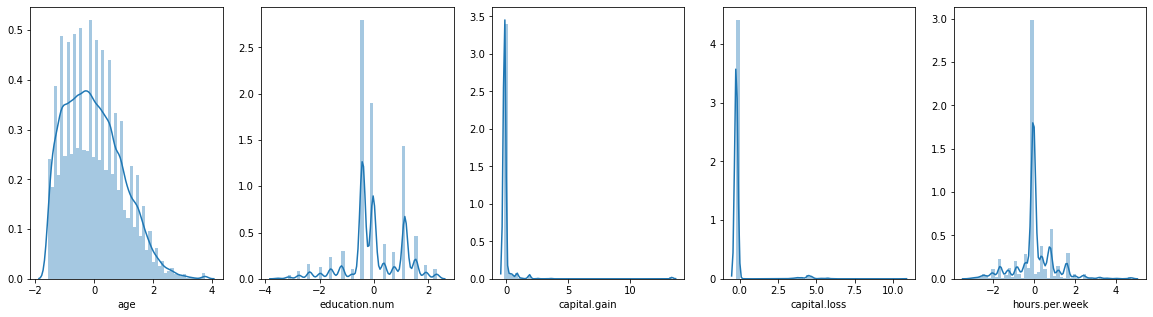

In [47]:
disp_feats = data.dtypes[data.dtypes == 'float64'].index.to_list()
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(len(disp_feats)):
    sns.distplot(data[disp_feats[i]], ax=axes[i], kde_kws={'bw':0.1})

Создаю датафрейм с корреляцией между признаками и таргетом

In [48]:
params = []
correlation = []
abs_corr = []
for c in data.columns:
    if c != 'income':
        if data[c].nunique() <= 2:
            corr = spearmanr(data['income'], data[c])[0]
        else:
            corr = pointbiserialr(data['income'], data[c])[0]
        params.append(c)
        correlation.append(corr)
        abs_corr.append(abs(corr))
        
params_df = pd.DataFrame({
    'correlation': correlation,
    'parameters': params,
    'abs_corr': abs_corr
})
params_df = params_df.sort_values(by=['abs_corr'], ascending=False).set_index('parameters')
params_df

,correlation,abs_corr
parameters,,
marital.status_Married-civ-spouse,0.445418,0.445418
relationship_Husband,0.401236,0.401236
education.num,0.335286,0.335286
marital.status_Never-married,-0.320053,0.320053
age,0.241998,0.241998
...,...,...
native.country_Cuba,0.002919,0.002919
native.country_Ireland,-0.002649,0.002649
education_Assoc-acdm,0.002170,0.002170


Отбрасываю признаки, которые слабо коррелируют с таргетом

In [49]:
feat_slice = params_df[params_df['abs_corr'] >= 0.1].index.to_list()

In [50]:
data[feat_slice].head()

,marital.status_Married-civ-spouse,relationship_Husband,education.num,marital.status_Never-married,age,hours.per.week,relationship_Own-child,capital.gain,sex_1,sex_2,...,occupation_Other-service,education_Prof-school,capital.loss,relationship_Unmarried,workclass_Self-emp-inc,education_HS-grad,marital.status_Divorced,education_Doctorate,relationship_Wife,workclass_Private
1,0,0,-0.420060,0,3.183112,-1.817204,0,-0.14592,1,0,...,0,0,10.593507,0,0,1,0,0,0,1
3,0,0,-2.363558,0,1.130359,-0.035429,0,-0.14592,1,0,...,0,0,9.461864,1,0,0,1,0,0,1
4,0,0,-0.031360,0,0.177296,-0.035429,1,-0.14592,1,0,...,0,0,9.461864,0,0,0,0,0,0,1
5,0,0,-0.420060,0,-0.335892,0.369519,0,-0.14592,1,0,...,1,0,9.139246,1,0,1,1,0,0,1
6,0,0,-1.586158,0,-0.042642,-0.035429,0,-0.14592,0,1,...,0,0,9.139246,1,0,0,0,0,0,1


In [51]:
# X = data.drop('income', axis=1)
# y = data['income']

X = data[feat_slice]
y = data['income']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)

In [53]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22621, 25), (7541, 25), (22621,), (7541,))

### RandomForestClassifier

In [54]:
rf = RandomForestClassifier(n_estimators=300, max_depth=5, 
                            random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(accuracy_score(rf_pred, y_test))

0.8415329531892322


Провожу кроссвалидацию StratifiedKFold, разбивая на 5 фолдов, каждый раз перемешивая данные. \
Подбираю гиперпараметры для RandomForestClassifier с помощью GridSearchCV, обучаю и делаю предикт.

In [55]:
%%time
preds = []
params_rf = {
    'n_estimators': np.arange(350, 550, 50),
#     'criterion': ['gini', 'entropy'],
    'max_depth' : np.arange(3, 10),
#     'max_features': ['auto', 2, 3],
#     'min_samples_leaf': [3, 4, 5],
}
i = 1
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X.index, y)

for train_index, test_index in skf.split(X.index, y):
    print(f'\n{i} of fold {skf.n_splits}')
    xtr, xvl = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    ytr, yvl = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
    gs_rf_model = GridSearchCV(rf, param_grid=params_rf, 
                               cv=5, scoring='accuracy', n_jobs=-1)
    gs_rf_model.fit(xtr, ytr)
    print(gs_rf_model.best_params_)
    pred = gs_rf_model.predict(xvl)
    print(f'accuracy_score = {accuracy_score(yvl, pred)}')
    preds.append(accuracy_score(yvl, pred))
    i += 1


1 of fold 5
{'max_depth': 6, 'n_estimators': 450}
accuracy_score = 0.8495781726799497

2 of fold 5
{'max_depth': 7, 'n_estimators': 450}
accuracy_score = 0.848

3 of fold 5
{'max_depth': 6, 'n_estimators': 500}
accuracy_score = 0.8602954262324257

4 of fold 5
{'max_depth': 6, 'n_estimators': 400}
accuracy_score = 0.8498207885304659

5 of fold 5
{'max_depth': 7, 'n_estimators': 500}
accuracy_score = 0.8510600071864894
Wall time: 48min 54s


In [57]:
gs_rf_model.best_params_

{'max_depth': 7, 'n_estimators': 500}

Берем среднее значение из всех предсказаний.

In [58]:
rf_score = np.array(preds).mean(axis=0)
rf_score

0.8517508789258661

Обучаю новую модель с подобранными гиперпараметрами

In [88]:
%%time
final_rf_preds = []
roc_auc = []
i = 1
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X.index, y)

for train_index, test_index in skf.split(X.index, y):
    print(f'\n{i} of fold {skf.n_splits}')
    xtr, xvl = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    ytr, yvl = y[y.index.isin(train_index)], y[y.index.isin(test_index)]

    new_rf = RandomForestClassifier(n_estimators=500, max_depth=9,
                                    random_state=42, min_samples_leaf=5, n_jobs=-1)
    new_rf.fit(xtr, ytr)
    pred = new_rf.predict(xvl)
    print(f'accuracy_score = {accuracy_score(yvl, pred)}')
    print(f'roc_auc_score = {roc_auc_score(yvl, pred)}')
    final_rf_preds.append(accuracy_score(yvl, pred))
    roc_auc.append(roc_auc_score(yvl, pred))
    i += 1


1 of fold 5
accuracy_score = 0.8544246993358463
roc_auc_score = 0.7566668807698372

2 of fold 5
accuracy_score = 0.8497777777777777
roc_auc_score = 0.7509460869462212

3 of fold 5
accuracy_score = 0.8675920982381207
roc_auc_score = 0.7790331373635418

4 of fold 5
accuracy_score = 0.8550179211469534
roc_auc_score = 0.7623349482540471

5 of fold 5
accuracy_score = 0.8564498742364355
roc_auc_score = 0.7590579478609158
Wall time: 19.6 s


Берем среднее значение из всех предсказаний.

In [90]:
# accuracy score
final_rf_score = np.array(final_rf_preds).mean(axis=0)
final_rf_score

0.8566524741470267

In [89]:
# roc_auc score
roc_auc_rf_score = np.array(roc_auc).mean(axis=0)
roc_auc_rf_score

0.7616078002389126

### Logistic Regression

In [103]:
%%time
lr_preds = []
roc_auc = []
param_lr = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
i = 1
lr = LogisticRegression(random_state=42, penalty='l1', solver='liblinear')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X.index, y)

for train_index, test_index in skf.split(X.index, y):
    print(f'\n{i} of fold {skf.n_splits}')
    xtr, xvl = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    ytr, yvl = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
    gs_lr_model = GridSearchCV(lr, param_grid=param_lr, cv=5, n_jobs=-1)
    gs_lr_model.fit(xtr, ytr)
    print(gs_lr_model.best_params_)
    lr_pred = gs_lr_model.predict(xvl)
    print(f'accuracy_score = {accuracy_score(yvl, lr_pred)}')
    print(f'roc_auc_score = {roc_auc_score(yvl, lr_pred)}')
    lr_preds.append(accuracy_score(yvl, lr_pred))
    roc_auc.append(roc_auc_score(yvl, lr_pred))
    i += 1


1 of fold 5
{'C': 0.01}
accuracy_score = 0.8398851193681566
roc_auc_score = 0.7460150190511748

2 of fold 5
{'C': 0.05}
accuracy_score = 0.8421333333333333
roc_auc_score = 0.7564739624960968

3 of fold 5
{'C': 0.05}
accuracy_score = 0.8522868837871508
roc_auc_score = 0.7718333949909806

4 of fold 5
{'C': 0.05}
accuracy_score = 0.8406810035842294
roc_auc_score = 0.7570958057120611

5 of fold 5
{'C': 0.05}
accuracy_score = 0.8424362199065757
roc_auc_score = 0.7573713968653702
Wall time: 1min 40s


In [71]:
# accuracy score
lr_score = np.array(lr_preds).mean(axis=0)
lr_score

0.8434845119958891

In [77]:
best_lr_model = gs_lr_model.best_estimator_
gs_lr_model.best_params_

{'C': 0.05}

In [98]:
%%time
final_lr_preds = []
roc_auc = []
i = 1
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X.index, y)

for train_index, test_index in skf.split(X.index, y):
    print(f'\n{i} of fold {skf.n_splits}')
    xtr, xvl = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    ytr, yvl = y[y.index.isin(train_index)], y[y.index.isin(test_index)]

    best_lr_model.fit(xtr, ytr)
    pred = best_lr_model.predict(xvl)
    print(f'accuracy_score = {accuracy_score(yvl, pred)}')
    print(f'roc_auc_score = {roc_auc_score(yvl, pred)}')
    final_lr_preds.append(accuracy_score(yvl, pred))
    roc_auc.append(roc_auc_score(yvl, pred))
    i += 1


1 of fold 5
accuracy_score = 0.8409621252916891
roc_auc_score = 0.7543804993458404

2 of fold 5
accuracy_score = 0.8421333333333333
roc_auc_score = 0.7564739624960968

3 of fold 5
accuracy_score = 0.8522868837871508
roc_auc_score = 0.7718333949909806

4 of fold 5
accuracy_score = 0.8406810035842294
roc_auc_score = 0.7570958057120611

5 of fold 5
accuracy_score = 0.8424362199065757
roc_auc_score = 0.7573713968653702
Wall time: 2.02 s


In [99]:
# accuracy score
final_lr_score = np.array(final_lr_preds).mean(axis=0)
final_lr_score

0.8436999131805957

In [101]:
# roc_auc score
roc_auc_lr_score = np.array(roc_auc).mean(axis=0)
roc_auc_lr_score

0.7594310118820699

### GaussianNaiveBayes

In [112]:
%%time
final_gnb_preds = []
roc_auc = []
i = 1
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X.index, y)

for train_index, test_index in skf.split(X.index, y):
    print(f'\n{i} of fold {skf.n_splits}')
    xtr, xvl = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    ytr, yvl = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
    gnb = GaussianNB()
    gnb.fit(xtr, ytr)
    pred = gnb.predict(xvl)
    print(f'accuracy_score = {accuracy_score(yvl, pred)}')
    print(f'roc_auc_score = {roc_auc_score(yvl, pred)}')
    final_gnb_preds.append(accuracy_score(yvl, pred))
    roc_auc.append(roc_auc_score(yvl, pred))
    i += 1


1 of fold 5
accuracy_score = 0.8255250403877221
roc_auc_score = 0.7878188062042291

2 of fold 5
accuracy_score = 0.8282666666666667
roc_auc_score = 0.7945435765952847

3 of fold 5
accuracy_score = 0.8229222281544759
roc_auc_score = 0.7927968524826243

4 of fold 5
accuracy_score = 0.8204301075268817
roc_auc_score = 0.7859710747153161

5 of fold 5
accuracy_score = 0.8219547251167805
roc_auc_score = 0.7840353301504093
Wall time: 238 ms


In [116]:
# accuracy score
final_gnb_score = np.array(final_gnb_preds).mean(axis=0)
final_gnb_score

0.8238197535705053

In [114]:
# roc_auc score
roc_auc_gnb_score = np.array(roc_auc).mean(axis=0)
roc_auc_gnb_score

0.7890331280295726

### CatBoostClassifier

In [190]:
%%time
cat_preds = []
i = 1
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X.index, y)

for train_index, test_index in skf.split(X.index, y):
    print(f'\n{i} of fold {skf.n_splits}')
    xtr, xvl = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    ytr, yvl = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
    cat = CatBoostClassifier(iterations=300, learning_rate=1e-2, 
                             depth=12, verbose=True, use_best_model=True, 
                             eval_metric='Accuracy', l2_leaf_reg=10, 
                             early_stopping_rounds=50, custom_metric=['Accuracy', 'AUC'])
    cat.fit(xtr, ytr, eval_set=(xvl, yvl))
    pred = cat.predict(xvl)
    cat_preds.append(cat.get_best_score()['validation']['Accuracy'])
    i += 1


1 of fold 5
0:	learn: 0.8443948	test: 0.8337821	best: 0.8337821 (0)	total: 129ms	remaining: 38.7s
1:	learn: 0.8510496	test: 0.8436546	best: 0.8436546 (1)	total: 411ms	remaining: 1m 1s
2:	learn: 0.8509603	test: 0.8450906	best: 0.8450906 (2)	total: 683ms	remaining: 1m 7s
3:	learn: 0.8507369	test: 0.8456292	best: 0.8456292 (3)	total: 965ms	remaining: 1m 11s
4:	learn: 0.8505136	test: 0.8452701	best: 0.8456292 (3)	total: 1s	remaining: 59.2s
5:	learn: 0.8507816	test: 0.8454496	best: 0.8456292 (3)	total: 1.26s	remaining: 1m 1s
6:	learn: 0.8509603	test: 0.8441931	best: 0.8456292 (3)	total: 1.49s	remaining: 1m 2s
7:	learn: 0.8502903	test: 0.8452701	best: 0.8456292 (3)	total: 1.51s	remaining: 55s
8:	learn: 0.8507369	test: 0.8454496	best: 0.8456292 (3)	total: 1.72s	remaining: 55.5s
9:	learn: 0.8509603	test: 0.8456292	best: 0.8456292 (3)	total: 1.91s	remaining: 55.5s
10:	learn: 0.8505136	test: 0.8458087	best: 0.8458087 (10)	total: 2.13s	remaining: 55.8s
11:	learn: 0.8500223	test: 0.8452701	best: 

94:	learn: 0.8590442	test: 0.8533477	best: 0.8537067 (88)	total: 18.4s	remaining: 39.7s
95:	learn: 0.8589549	test: 0.8531682	best: 0.8537067 (88)	total: 18.7s	remaining: 39.6s
96:	learn: 0.8589549	test: 0.8529887	best: 0.8537067 (88)	total: 18.9s	remaining: 39.5s
97:	learn: 0.8590889	test: 0.8529887	best: 0.8537067 (88)	total: 19s	remaining: 39.2s
98:	learn: 0.8590442	test: 0.8531682	best: 0.8537067 (88)	total: 19.2s	remaining: 39s
99:	learn: 0.8589996	test: 0.8531682	best: 0.8537067 (88)	total: 19.4s	remaining: 38.9s
100:	learn: 0.8588209	test: 0.8533477	best: 0.8537067 (88)	total: 19.6s	remaining: 38.7s
101:	learn: 0.8590889	test: 0.8535272	best: 0.8537067 (88)	total: 19.8s	remaining: 38.5s
102:	learn: 0.8589996	test: 0.8533477	best: 0.8537067 (88)	total: 19.9s	remaining: 38s
103:	learn: 0.8590889	test: 0.8535272	best: 0.8537067 (88)	total: 20.1s	remaining: 37.9s
104:	learn: 0.8591782	test: 0.8535272	best: 0.8537067 (88)	total: 20.4s	remaining: 37.8s
105:	learn: 0.8590889	test: 0.853

186:	learn: 0.8640018	test: 0.8563992	best: 0.8563992 (186)	total: 36.7s	remaining: 22.2s
187:	learn: 0.8642251	test: 0.8565787	best: 0.8565787 (187)	total: 36.9s	remaining: 22s
188:	learn: 0.8642251	test: 0.8563992	best: 0.8565787 (187)	total: 37.2s	remaining: 21.8s
189:	learn: 0.8644484	test: 0.8565787	best: 0.8565787 (187)	total: 37.4s	remaining: 21.7s
190:	learn: 0.8644931	test: 0.8563992	best: 0.8565787 (187)	total: 37.4s	remaining: 21.4s
191:	learn: 0.8644931	test: 0.8565787	best: 0.8565787 (187)	total: 37.6s	remaining: 21.2s
192:	learn: 0.8645824	test: 0.8565787	best: 0.8565787 (187)	total: 37.8s	remaining: 21s
193:	learn: 0.8645377	test: 0.8563992	best: 0.8565787 (187)	total: 38s	remaining: 20.8s
194:	learn: 0.8646717	test: 0.8563992	best: 0.8565787 (187)	total: 38.2s	remaining: 20.6s
195:	learn: 0.8648057	test: 0.8565787	best: 0.8565787 (187)	total: 38.4s	remaining: 20.4s
196:	learn: 0.8648057	test: 0.8565787	best: 0.8565787 (187)	total: 38.6s	remaining: 20.2s
197:	learn: 0.86

278:	learn: 0.8685574	test: 0.8589122	best: 0.8589122 (276)	total: 1m 11s	remaining: 5.35s
279:	learn: 0.8685574	test: 0.8590917	best: 0.8590917 (279)	total: 1m 11s	remaining: 5.12s
280:	learn: 0.8685127	test: 0.8592712	best: 0.8592712 (280)	total: 1m 12s	remaining: 4.88s
281:	learn: 0.8686467	test: 0.8592712	best: 0.8592712 (280)	total: 1m 12s	remaining: 4.64s
282:	learn: 0.8687807	test: 0.8592712	best: 0.8592712 (280)	total: 1m 13s	remaining: 4.39s
283:	learn: 0.8688254	test: 0.8592712	best: 0.8592712 (280)	total: 1m 13s	remaining: 4.14s
284:	learn: 0.8687807	test: 0.8592712	best: 0.8592712 (280)	total: 1m 14s	remaining: 3.9s
285:	learn: 0.8687807	test: 0.8594507	best: 0.8594507 (285)	total: 1m 14s	remaining: 3.64s
286:	learn: 0.8687360	test: 0.8592712	best: 0.8594507 (285)	total: 1m 14s	remaining: 3.38s
287:	learn: 0.8686467	test: 0.8592712	best: 0.8594507 (285)	total: 1m 15s	remaining: 3.13s
288:	learn: 0.8685127	test: 0.8592712	best: 0.8594507 (285)	total: 1m 15s	remaining: 2.88s


70:	learn: 0.8575394	test: 0.8453333	best: 0.8458667 (54)	total: 23.3s	remaining: 1m 15s
71:	learn: 0.8577633	test: 0.8456889	best: 0.8458667 (54)	total: 23.5s	remaining: 1m 14s
72:	learn: 0.8578080	test: 0.8462222	best: 0.8462222 (72)	total: 23.9s	remaining: 1m 14s
73:	learn: 0.8579423	test: 0.8467556	best: 0.8467556 (73)	total: 24.3s	remaining: 1m 14s
74:	learn: 0.8579423	test: 0.8467556	best: 0.8467556 (73)	total: 24.6s	remaining: 1m 13s
75:	learn: 0.8580319	test: 0.8464000	best: 0.8467556 (73)	total: 25s	remaining: 1m 13s
76:	learn: 0.8581214	test: 0.8467556	best: 0.8467556 (73)	total: 25.4s	remaining: 1m 13s
77:	learn: 0.8582110	test: 0.8464000	best: 0.8467556 (73)	total: 25.8s	remaining: 1m 13s
78:	learn: 0.8582110	test: 0.8464000	best: 0.8467556 (73)	total: 26.2s	remaining: 1m 13s
79:	learn: 0.8583005	test: 0.8467556	best: 0.8467556 (73)	total: 26.5s	remaining: 1m 12s
80:	learn: 0.8585244	test: 0.8469333	best: 0.8469333 (80)	total: 26.9s	remaining: 1m 12s
81:	learn: 0.8585691	te

162:	learn: 0.8630014	test: 0.8513778	best: 0.8513778 (160)	total: 56.1s	remaining: 47.1s
163:	learn: 0.8632253	test: 0.8512000	best: 0.8513778 (160)	total: 56.4s	remaining: 46.8s
164:	learn: 0.8632253	test: 0.8510222	best: 0.8513778 (160)	total: 56.8s	remaining: 46.5s
165:	learn: 0.8633148	test: 0.8513778	best: 0.8513778 (160)	total: 57.3s	remaining: 46.3s
166:	learn: 0.8633148	test: 0.8512000	best: 0.8513778 (160)	total: 57.5s	remaining: 45.8s
167:	learn: 0.8633148	test: 0.8513778	best: 0.8513778 (160)	total: 57.9s	remaining: 45.5s
168:	learn: 0.8635387	test: 0.8512000	best: 0.8513778 (160)	total: 58.9s	remaining: 45.7s
169:	learn: 0.8637178	test: 0.8512000	best: 0.8513778 (160)	total: 59.7s	remaining: 45.6s
170:	learn: 0.8637625	test: 0.8515556	best: 0.8515556 (170)	total: 1m	remaining: 45.3s
171:	learn: 0.8636282	test: 0.8513778	best: 0.8515556 (170)	total: 1m	remaining: 45.1s
172:	learn: 0.8637178	test: 0.8513778	best: 0.8515556 (170)	total: 1m	remaining: 44.7s
173:	learn: 0.86380

253:	learn: 0.8688216	test: 0.8533333	best: 0.8535111 (206)	total: 1m 34s	remaining: 17.1s
254:	learn: 0.8688216	test: 0.8533333	best: 0.8535111 (206)	total: 1m 34s	remaining: 16.7s
255:	learn: 0.8689112	test: 0.8533333	best: 0.8535111 (206)	total: 1m 34s	remaining: 16.3s
256:	learn: 0.8689559	test: 0.8535111	best: 0.8535111 (206)	total: 1m 35s	remaining: 15.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8535111111
bestIteration = 206

Shrink model to first 207 iterations.

3 of fold 5
0:	learn: 0.8403903	test: 0.8476597	best: 0.8476597 (0)	total: 294ms	remaining: 1m 27s
1:	learn: 0.8468803	test: 0.8585158	best: 0.8585158 (1)	total: 690ms	remaining: 1m 42s
2:	learn: 0.8482678	test: 0.8583378	best: 0.8585158 (1)	total: 1.08s	remaining: 1m 47s
3:	learn: 0.8492078	test: 0.8613632	best: 0.8613632 (3)	total: 1.43s	remaining: 1m 45s
4:	learn: 0.8473727	test: 0.8597615	best: 0.8613632 (3)	total: 1.51s	remaining: 1m 29s
5:	learn: 0.8477307	test: 0.8617192	best: 0.861719

87:	learn: 0.8563692	test: 0.8654565	best: 0.8656345 (86)	total: 31.2s	remaining: 1m 15s
88:	learn: 0.8564139	test: 0.8654565	best: 0.8656345 (86)	total: 31.6s	remaining: 1m 14s
89:	learn: 0.8566377	test: 0.8649226	best: 0.8656345 (86)	total: 31.9s	remaining: 1m 14s
90:	learn: 0.8566377	test: 0.8654565	best: 0.8656345 (86)	total: 32.3s	remaining: 1m 14s
91:	learn: 0.8568168	test: 0.8652785	best: 0.8656345 (86)	total: 32.7s	remaining: 1m 14s
92:	learn: 0.8565930	test: 0.8656345	best: 0.8656345 (86)	total: 33.1s	remaining: 1m 13s
93:	learn: 0.8567720	test: 0.8654565	best: 0.8656345 (86)	total: 33.4s	remaining: 1m 13s
94:	learn: 0.8569063	test: 0.8651006	best: 0.8656345 (86)	total: 33.8s	remaining: 1m 12s
95:	learn: 0.8571748	test: 0.8651006	best: 0.8656345 (86)	total: 34.2s	remaining: 1m 12s
96:	learn: 0.8570406	test: 0.8652785	best: 0.8656345 (86)	total: 34.6s	remaining: 1m 12s
97:	learn: 0.8569958	test: 0.8651006	best: 0.8656345 (86)	total: 35s	remaining: 1m 12s
98:	learn: 0.8570406	te

179:	learn: 0.8622326	test: 0.8677701	best: 0.8679480 (171)	total: 1m 12s	remaining: 48.3s
180:	learn: 0.8623668	test: 0.8677701	best: 0.8679480 (171)	total: 1m 13s	remaining: 48.1s
181:	learn: 0.8621878	test: 0.8677701	best: 0.8679480 (171)	total: 1m 13s	remaining: 47.8s
182:	learn: 0.8623221	test: 0.8677701	best: 0.8679480 (171)	total: 1m 14s	remaining: 47.4s
183:	learn: 0.8624116	test: 0.8677701	best: 0.8679480 (171)	total: 1m 14s	remaining: 46.9s
184:	learn: 0.8623668	test: 0.8679480	best: 0.8679480 (171)	total: 1m 14s	remaining: 46.6s
185:	learn: 0.8624116	test: 0.8679480	best: 0.8679480 (171)	total: 1m 15s	remaining: 46s
186:	learn: 0.8624564	test: 0.8675921	best: 0.8679480 (171)	total: 1m 15s	remaining: 45.5s
187:	learn: 0.8623668	test: 0.8675921	best: 0.8679480 (171)	total: 1m 15s	remaining: 45.1s
188:	learn: 0.8624564	test: 0.8675921	best: 0.8679480 (171)	total: 1m 16s	remaining: 44.7s
189:	learn: 0.8625459	test: 0.8679480	best: 0.8679480 (171)	total: 1m 16s	remaining: 44.3s
1

5:	learn: 0.8531344	test: 0.8473118	best: 0.8473118 (5)	total: 1.52s	remaining: 1m 14s
6:	learn: 0.8524195	test: 0.8480287	best: 0.8480287 (6)	total: 1.63s	remaining: 1m 8s
7:	learn: 0.8528663	test: 0.8478495	best: 0.8480287 (6)	total: 1.89s	remaining: 1m 9s
8:	learn: 0.8531790	test: 0.8480287	best: 0.8480287 (6)	total: 2.16s	remaining: 1m 9s
9:	learn: 0.8522854	test: 0.8473118	best: 0.8480287 (6)	total: 2.42s	remaining: 1m 10s
10:	learn: 0.8527769	test: 0.8483871	best: 0.8483871 (10)	total: 2.69s	remaining: 1m 10s
11:	learn: 0.8517493	test: 0.8483871	best: 0.8483871 (10)	total: 2.72s	remaining: 1m 5s
12:	learn: 0.8516152	test: 0.8474910	best: 0.8483871 (10)	total: 2.79s	remaining: 1m 1s
13:	learn: 0.8512131	test: 0.8467742	best: 0.8483871 (10)	total: 2.82s	remaining: 57.6s
14:	learn: 0.8509897	test: 0.8471326	best: 0.8483871 (10)	total: 3.08s	remaining: 58.6s
15:	learn: 0.8504088	test: 0.8469534	best: 0.8483871 (10)	total: 3.31s	remaining: 58.7s
16:	learn: 0.8506322	test: 0.8474910	be

99:	learn: 0.8592556	test: 0.8510753	best: 0.8514337 (79)	total: 29.6s	remaining: 59.2s
100:	learn: 0.8589875	test: 0.8510753	best: 0.8514337 (79)	total: 29.9s	remaining: 59s
101:	learn: 0.8593897	test: 0.8507168	best: 0.8514337 (79)	total: 30.3s	remaining: 58.7s
102:	learn: 0.8591663	test: 0.8507168	best: 0.8514337 (79)	total: 30.6s	remaining: 58.4s
103:	learn: 0.8595237	test: 0.8512545	best: 0.8514337 (79)	total: 30.9s	remaining: 58.2s
104:	learn: 0.8595237	test: 0.8516129	best: 0.8516129 (104)	total: 31.3s	remaining: 58.1s
105:	learn: 0.8595684	test: 0.8517921	best: 0.8517921 (105)	total: 31.7s	remaining: 57.9s
106:	learn: 0.8596577	test: 0.8516129	best: 0.8517921 (105)	total: 32.1s	remaining: 57.8s
107:	learn: 0.8595237	test: 0.8519713	best: 0.8519713 (107)	total: 32.4s	remaining: 57.6s
108:	learn: 0.8597024	test: 0.8517921	best: 0.8519713 (107)	total: 32.8s	remaining: 57.5s
109:	learn: 0.8597024	test: 0.8517921	best: 0.8519713 (107)	total: 33.2s	remaining: 57.3s
110:	learn: 0.8598

191:	learn: 0.8642599	test: 0.8535842	best: 0.8539427 (190)	total: 59.1s	remaining: 33.2s
192:	learn: 0.8642599	test: 0.8537634	best: 0.8539427 (190)	total: 59.5s	remaining: 33s
193:	learn: 0.8643492	test: 0.8539427	best: 0.8539427 (190)	total: 59.8s	remaining: 32.7s
194:	learn: 0.8643939	test: 0.8539427	best: 0.8539427 (190)	total: 1m	remaining: 32.4s
195:	learn: 0.8644833	test: 0.8539427	best: 0.8539427 (190)	total: 1m	remaining: 32.1s
196:	learn: 0.8644833	test: 0.8537634	best: 0.8539427 (190)	total: 1m	remaining: 31.8s
197:	learn: 0.8645726	test: 0.8539427	best: 0.8539427 (190)	total: 1m 1s	remaining: 31.6s
198:	learn: 0.8645726	test: 0.8537634	best: 0.8539427 (190)	total: 1m 1s	remaining: 31.4s
199:	learn: 0.8644833	test: 0.8535842	best: 0.8539427 (190)	total: 1m 2s	remaining: 31.2s
200:	learn: 0.8646620	test: 0.8535842	best: 0.8539427 (190)	total: 1m 2s	remaining: 31s
201:	learn: 0.8647067	test: 0.8535842	best: 0.8539427 (190)	total: 1m 3s	remaining: 30.8s
202:	learn: 0.8648854	t

282:	learn: 0.8686833	test: 0.8564516	best: 0.8569892 (252)	total: 1m 38s	remaining: 5.91s
283:	learn: 0.8687726	test: 0.8568100	best: 0.8569892 (252)	total: 1m 38s	remaining: 5.57s
284:	learn: 0.8686833	test: 0.8568100	best: 0.8569892 (252)	total: 1m 39s	remaining: 5.22s
285:	learn: 0.8685939	test: 0.8568100	best: 0.8569892 (252)	total: 1m 39s	remaining: 4.87s
286:	learn: 0.8686386	test: 0.8571685	best: 0.8571685 (286)	total: 1m 39s	remaining: 4.53s
287:	learn: 0.8686833	test: 0.8569892	best: 0.8571685 (286)	total: 1m 40s	remaining: 4.18s
288:	learn: 0.8686833	test: 0.8573477	best: 0.8573477 (288)	total: 1m 40s	remaining: 3.83s
289:	learn: 0.8686833	test: 0.8573477	best: 0.8573477 (288)	total: 1m 41s	remaining: 3.49s
290:	learn: 0.8687279	test: 0.8571685	best: 0.8573477 (288)	total: 1m 41s	remaining: 3.15s
291:	learn: 0.8687279	test: 0.8571685	best: 0.8573477 (288)	total: 1m 42s	remaining: 2.8s
292:	learn: 0.8689960	test: 0.8573477	best: 0.8573477 (288)	total: 1m 42s	remaining: 2.45s


73:	learn: 0.8569324	test: 0.8532160	best: 0.8535753 (56)	total: 26.6s	remaining: 1m 21s
74:	learn: 0.8573342	test: 0.8528566	best: 0.8535753 (56)	total: 26.9s	remaining: 1m 20s
75:	learn: 0.8574235	test: 0.8526770	best: 0.8535753 (56)	total: 27.3s	remaining: 1m 20s
76:	learn: 0.8575128	test: 0.8526770	best: 0.8535753 (56)	total: 27.7s	remaining: 1m 20s
77:	learn: 0.8572003	test: 0.8530363	best: 0.8535753 (56)	total: 28.1s	remaining: 1m 19s
78:	learn: 0.8575128	test: 0.8528566	best: 0.8535753 (56)	total: 28.4s	remaining: 1m 19s
79:	learn: 0.8576914	test: 0.8528566	best: 0.8535753 (56)	total: 28.9s	remaining: 1m 19s
80:	learn: 0.8577361	test: 0.8526770	best: 0.8535753 (56)	total: 29.3s	remaining: 1m 19s
81:	learn: 0.8577361	test: 0.8523176	best: 0.8535753 (56)	total: 29.6s	remaining: 1m 18s
82:	learn: 0.8577361	test: 0.8523176	best: 0.8535753 (56)	total: 30s	remaining: 1m 18s
83:	learn: 0.8580040	test: 0.8524973	best: 0.8535753 (56)	total: 30.5s	remaining: 1m 18s
84:	learn: 0.8578254	te

165:	learn: 0.8627819	test: 0.8555516	best: 0.8560905 (151)	total: 59.1s	remaining: 47.7s
166:	learn: 0.8627819	test: 0.8557312	best: 0.8560905 (151)	total: 59.8s	remaining: 47.6s
167:	learn: 0.8629605	test: 0.8555516	best: 0.8560905 (151)	total: 1m	remaining: 47.3s
168:	learn: 0.8631837	test: 0.8555516	best: 0.8560905 (151)	total: 1m	remaining: 47s
169:	learn: 0.8630051	test: 0.8557312	best: 0.8560905 (151)	total: 1m	remaining: 46.6s
170:	learn: 0.8630051	test: 0.8551922	best: 0.8560905 (151)	total: 1m 1s	remaining: 46.3s
171:	learn: 0.8630944	test: 0.8557312	best: 0.8560905 (151)	total: 1m 1s	remaining: 45.9s
172:	learn: 0.8629605	test: 0.8557312	best: 0.8560905 (151)	total: 1m 2s	remaining: 45.6s
173:	learn: 0.8631391	test: 0.8557312	best: 0.8560905 (151)	total: 1m 2s	remaining: 45.2s
174:	learn: 0.8632731	test: 0.8557312	best: 0.8560905 (151)	total: 1m 2s	remaining: 44.9s
175:	learn: 0.8632731	test: 0.8559109	best: 0.8560905 (151)	total: 1m 3s	remaining: 44.5s
176:	learn: 0.8633177

256:	learn: 0.8677830	test: 0.8586058	best: 0.8586058 (215)	total: 1m 40s	remaining: 16.9s
257:	learn: 0.8677830	test: 0.8587855	best: 0.8587855 (257)	total: 1m 41s	remaining: 16.5s
258:	learn: 0.8679616	test: 0.8587855	best: 0.8587855 (257)	total: 1m 41s	remaining: 16.1s
259:	learn: 0.8680509	test: 0.8587855	best: 0.8587855 (257)	total: 1m 42s	remaining: 15.8s
260:	learn: 0.8680956	test: 0.8589651	best: 0.8589651 (260)	total: 1m 42s	remaining: 15.4s
261:	learn: 0.8679616	test: 0.8591448	best: 0.8591448 (261)	total: 1m 43s	remaining: 15s
262:	learn: 0.8677830	test: 0.8593245	best: 0.8593245 (262)	total: 1m 43s	remaining: 14.6s
263:	learn: 0.8680063	test: 0.8591448	best: 0.8593245 (262)	total: 1m 44s	remaining: 14.2s
264:	learn: 0.8678723	test: 0.8593245	best: 0.8593245 (262)	total: 1m 44s	remaining: 13.8s
265:	learn: 0.8678276	test: 0.8593245	best: 0.8593245 (262)	total: 1m 45s	remaining: 13.5s
266:	learn: 0.8679616	test: 0.8593245	best: 0.8593245 (262)	total: 1m 45s	remaining: 13.1s
2

In [191]:
# accuracy score # best params d=12, l2=10, 1e-2
cat_score = np.array(cat_preds).mean(axis=0)
cat_score

0.8600160673668531

In [195]:
cat.get_best_score()['validation']['AUC']

0.9188701999884462

Можно заметить, что CatBoostClassifier выдает лучший результат даже без подбора гиперпараметров GridSearchCV

### DecisionTreeClassifier

Точность алгоритмов:
<ul>
    <li>RandomForest: 85.66%</li>
    <li>LogisticRegression: 84.36%</li>
    <li>GaussianNB: 82.4%</li>
    <li>CatBoostClassifier: 86%</li>
    <li>DecisionTreeClassifier</li>
</ul>